# Deep Q-learning (DQL) or Deep Q-network (DQN)

In this notebook, we'll build a neural network that can learn to play games through reinforcement learning. More specifically, we'll use Q-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
import numpy as np

In [2]:
import tensorflow as tf
print('TensorFlow Version: {}'.format(tf.__version__))
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.12.0
Default GPU Device: /device:GPU:0


>**Note:** Make sure you have OpenAI Gym cloned into the same directory with this notebook. I've included `gym` as a submodule, so you can run `git submodule --init --recursive` to pull the contents into the `gym` repo.

>**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [3]:
import gym

## Create the Cart-Pole game environment
# env = gym.make('CartPole-v0') # 200 total reward as goal
env = gym.make('CartPole-v1') # 500 total reward as goal

We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [4]:
# env.reset()
# batch = []
# for _ in range(1000):
#     # env.render()
#     action = env.action_space.sample()
#     state, reward, done, info = env.step(action) # take a random action
#     batch.append([action, state, reward, done, info])
#     #print('state, action, reward, done, info:', state, action, reward, done, info)
#     if done:
#         env.reset()

To shut the window showing the simulation, use `env.close()`.

If you ran the simulation above, we can look at the rewards:

In [5]:
# batch[0], batch[0][1].shape

In [6]:
# actions = np.array([each[0] for each in batch])
# states = np.array([each[1] for each in batch])
# rewards = np.array([each[2] for each in batch])
# dones = np.array([each[3] for each in batch])
# infos = np.array([each[4] for each in batch])

In [7]:
# print(rewards[-20:])
# print(np.array(rewards).shape, np.array(states).shape, np.array(actions).shape, np.array(dones).shape)
# print(np.array(rewards).dtype, np.array(states).dtype, np.array(actions).dtype, np.array(dones).dtype)
# print(np.max(np.array(actions)), np.min(np.array(actions)))
# print((np.max(np.array(actions)) - np.min(np.array(actions)))+1)
# print(np.max(np.array(rewards)), np.min(np.array(rewards)))
# print(np.max(np.array(states)), np.min(np.array(states)))

The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## Q-Network

We train our Q-learning agent using the Bellman Equation:

$$
Q(s, a) = r + \gamma \max{Q(s', a')}
$$

where $s$ is a state, $a$ is an action, and $s'$ is the next state from state $s$ and action $a$.

Before we used this equation to learn values for a Q-_table_. However, for this game there are a huge number of states available. The state has four values: the position and velocity of the cart, and the position and velocity of the pole. These are all real-valued numbers, so ignoring floating point precisions, you practically have infinite states. Instead of using a table then, we'll replace it with a neural network that will approximate the Q-table lookup function.

<img src="assets/deep-q-learning.png" width=450px>

Now, our Q value, $Q(s, a)$ is calculated by passing in a state to the network. The output will be Q-values for each available action, with fully connected hidden layers.

<img src="assets/q-network.png" width=550px>


As I showed before, we can define our targets for training as $\hat{Q}(s,a) = r + \gamma \max{Q(s', a')}$. Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

For this Cart-Pole game, we have four inputs, one for each value in the state, and two outputs, one for each action. To get $\hat{Q}$, we'll first choose an action, then simulate the game using that action. This will get us the next state, $s'$, and the reward. With that, we can calculate $\hat{Q}$ then pass it back into the $Q$ network to run the optimizer and update the weights.

Below is my implementation of the Q-network. I used two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [8]:
def model_input(state_size, action_size):
    actions = tf.placeholder(tf.int32, [None], name='actions')
    actions_logits = tf.placeholder(tf.float32, [None, action_size], name='actions_logits')
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    next_states = tf.placeholder(tf.float32, [None, state_size], name='next_states')
    targetQs = tf.placeholder(tf.float32, [None], name='targetQs')
    is_training = tf.placeholder(tf.bool, name='is_training')
    return actions, actions_logits, states, next_states, targetQs, is_training

In [9]:
def init_xavier(random_seed=1, dtype=tf.float32, uniform=False):
    xavier = tf.contrib.layers.xavier_initializer(
        dtype=dtype,
        seed=tf.set_random_seed(random_seed), 
        uniform=uniform) # False: normal
    return xavier

In [10]:
def mlp(inputs, units, trainable=True):
    outputs = tf.layers.dense(
        inputs=inputs,
        units=units,
        activation=None,
        use_bias=True,
        kernel_initializer=init_xavier(), # Xavier with normal init
        bias_initializer=tf.zeros_initializer(),
        kernel_regularizer=None,
        bias_regularizer=None,
        activity_regularizer=None,
        kernel_constraint=None,
        bias_constraint=None,
        trainable=trainable,
        name=None,
        reuse=None)
    return outputs

In [11]:
# tf.nn.leaky_relu(
#     features,
#     alpha=0.2,
#     name=None
# )
def nl(inputs, alpha=0.2):
    outputs = tf.maximum(alpha * inputs, inputs)
    return outputs

In [12]:
def bn(inputs, training=False):
    outputs = tf.layers.batch_normalization(
        inputs=inputs,
        axis=-1,
        momentum=0.99,
        epsilon=0.001,
        center=True,
        scale=True,
        beta_initializer=tf.zeros_initializer(),
        gamma_initializer=tf.ones_initializer(),
        moving_mean_initializer=tf.zeros_initializer(),
        moving_variance_initializer=tf.ones_initializer(),
        beta_regularizer=None,
        gamma_regularizer=None,
        beta_constraint=None,
        gamma_constraint=None,
        training=training,
        trainable=True,
        name=None,
        reuse=None,
        renorm=False,
        renorm_clipping=None,
        renorm_momentum=0.99,
        fused=None,
        virtual_batch_size=None,
        adjustment=None)
    return outputs

In [15]:
# Generator/Autorencoder/Adv
def G(states, actions_logits, state_size, hidden_size, reuse=False, alpha=0.2, is_training=False):
    with tf.variable_scope('G', reuse=reuse):
        # First fully connected layer
        h1 = mlp(inputs=states, units=hidden_size)
        h1 = bn(inputs=h1, training=is_training)
        h1 = nl(h1)
        print(states.shape, h1.shape)
        
        # Second fully connected layer
        h2 = tf.concat([h1, actions_logits], axis=1)
        h2 = mlp(inputs=h2, units=hidden_size)
        #h2 += h1
        h2 = bn(inputs=h2, training=is_training)
        h2 = nl(h2)
        print(h2.shape)
        
        # Output layer
        next_states_ = mlp(inputs=h2, units=state_size)
        return next_states_

In [16]:
# Actor-Critic/ D/Q
def D(states, action_size, hidden_size, reuse=False, alpha=0.2, is_training=False):
    with tf.variable_scope('D', reuse=reuse):
        # First fully connected layer
        h1 = mlp(inputs=states, units=hidden_size)
        h1 = bn(inputs=h1, training=is_training)
        h1 = nl(h1)
        print(states.shape, h1.shape)
        
        # Second fully connected layer
        h2 = mlp(inputs=h1, units=hidden_size)
        #h2 += h1
        h2 = bn(inputs=h2, training=is_training)
        h2 = nl(h2)
        print(h2.shape)
        
        # Output layer
        actions_ = mlp(inputs=h2, units=action_size)
        return actions_

In [17]:
def model_loss(actions, actions_logits, states, next_states, targetQs, 
               state_size, action_size, hidden_size, 
               is_training=False):

    next_states_ = G(states=states, actions_logits=actions_logits, hidden_size=hidden_size, 
                     state_size=state_size, is_training=is_training)
    
    gloss = tf.reduce_mean(tf.reduce_sum((next_states - next_states_)**2, axis=1))

    actions_logits_ = D(states=states, hidden_size=hidden_size, action_size=action_size, 
                        is_training=is_training)
    
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits_.dtype)
    
    Qs = tf.reduce_max(actions_logits_ * actions_labels, axis=1)
    
    dloss = tf.reduce_mean((Qs - targetQs)**2)
    
    return actions_logits_, next_states_, gloss, dloss

In [18]:
def model_opt(gloss, dloss, learning_rate):
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('G')]
    d_vars = [var for var in t_vars if var.name.startswith('D')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        g_opt = tf.train.AdamOptimizer(learning_rate).minimize(gloss, var_list=g_vars)
        d_opt = tf.train.AdamOptimizer(learning_rate).minimize(dloss, var_list=d_vars)

    return g_opt, d_opt

In [19]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, learning_rate):

        # Data of the Model: make the data available inside the framework
        (self.actions, self.actions_logits, self.states, self.next_states, self.targetQs, \
         self.is_training) = model_input(state_size=state_size, action_size=action_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits_, self.next_states_, self.gloss, self.dloss = model_loss(
            action_size=action_size, hidden_size=hidden_size, state_size=state_size,
            states=self.states, next_states=self.next_states, 
            actions=self.actions, actions_logits=self.actions_logits,
            targetQs=self.targetQs, is_training=self.is_training)

        # Update the model: backward pass and backprop
        self.g_opt, self.d_opt = model_opt(gloss=self.gloss, dloss=self.dloss, learning_rate=learning_rate)

## Experience replay

Reinforcement learning algorithms can have stability issues due to correlations between states. To reduce correlations when training, we can store the agent's experiences and later draw a random mini-batch of those experiences to train on. 

Here, we'll create a `Memory` object that will store our experiences, our transitions $<s, a, r, s'>$. This memory will have a maxmium capacity, so we can keep newer experiences in memory while getting rid of older experiences. Then, we'll sample a random mini-batch of transitions $<s, a, r, s'>$ and train on those.

Below, I've implemented a `Memory` object. If you're unfamiliar with `deque`, this is a double-ended queue. You can think of it like a tube open on both sides. You can put objects in either side of the tube. But if it's full, adding anything more will push an object out the other side. This is a great data structure to use for the memory buffer.

In [20]:
from collections import deque
class Memory():
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size)
    def sample(self, batch_size):
        idx = np.random.choice(np.arange(len(self.buffer)), 
                               size=batch_size, 
                               replace=False)
        return [self.buffer[ii] for ii in idx]

## Exploration - Exploitation

To learn about the environment and rules of the game, the agent needs to explore by taking random actions. We'll do this by choosing a random action with some probability $\epsilon$ (epsilon).  That is, with some probability $\epsilon$ the agent will make a random action and with probability $1 - \epsilon$, the agent will choose an action from $Q(s,a)$. This is called an **$\epsilon$-greedy policy**.


At first, the agent needs to do a lot of exploring. Later when it has learned more, the agent can favor choosing actions based on what it has learned. This is called _exploitation_. We'll set it up so the agent is more likely to explore early in training, then more likely to exploit later in training.

## Q-Learning training algorithm

Putting all this together, we can list out the algorithm we'll use to train the network. We'll train the network in _episodes_. One *episode* is one simulation of the game. For this game, the goal is to keep the pole upright for 195 frames. So we can start a new episode once meeting that goal. The game ends if the pole tilts over too far, or if the cart moves too far the left or right. When a game ends, we'll start a new episode. Now, to train the agent:

* Initialize the memory $D$
* Initialize the action-value network $Q$ with random weights
* **For** episode = 1, $M$ **do**
  * **For** $t$, $T$ **do**
     * With probability $\epsilon$ select a random action $a_t$, otherwise select $a_t = \mathrm{argmax}_a Q(s,a)$
     * Execute action $a_t$ in simulator and observe reward $r_{t+1}$ and new state $s_{t+1}$
     * Store transition $<s_t, a_t, r_{t+1}, s_{t+1}>$ in memory $D$
     * Sample random mini-batch from $D$: $<s_j, a_j, r_j, s'_j>$
     * Set $\hat{Q}_j = r_j$ if the episode ends at $j+1$, otherwise set $\hat{Q}_j = r_j + \gamma \max_{a'}{Q(s'_j, a')}$
     * Make a gradient descent step with loss $(\hat{Q}_j - Q(s_j, a_j))^2$
  * **endfor**
* **endfor**

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [21]:
# print('state size:{}'.format(states.shape), 
#       'actions:{}'.format(actions.shape)) 
# print('action size:', np.max(actions) - np.min(actions)+1)

In [23]:
# Network parameters
action_size = 2
state_size = 4
hidden_size = 64               # number of units in each Q-network hidden layer
learning_rate = 1e-04         # Q-network learning rate

# Memory parameters
memory_size = int(1e5)            # memory capacity
batch_size = 20             # experience mini-batch size
gamma = 0.99                 # future reward discount

In [24]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, hidden_size=hidden_size, state_size=state_size, learning_rate=learning_rate)

# Init the memory
memory = Memory(max_size=memory_size)

(?, 4) (?, 64)
(?, 64)
(?, 4) (?, 64)
(?, 64)


## Populate the memory (exprience memory)

Here I'm re-initializing the simulation and pre-populating the memory. The agent is taking random actions and storing the transitions in memory. This will help the agent with exploring the game.

In [25]:
# state = env.reset()

# for _ in range(memory_size):
    
#     action = env.action_space.sample()
    
#     next_state, reward, done, _ = env.step(action)
    
#     memory.buffer.append([state, action, next_state, reward, float(done)])
    
#     state = next_state
    
#     if done is True:
#         state = env.reset()

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [26]:
def learn(sess, memory, batch_size):
    
    batch = memory.sample(batch_size)
    states = np.array([each[0] for each in batch])
    actions = np.array([each[1] for each in batch])
    next_states = np.array([each[2] for each in batch])
    rewards = np.array([each[3] for each in batch])
    dones = np.array([each[4] for each in batch])
    actions_logits = np.array([each[5] for each in batch])
    
    next_actions_logits_ = sess.run(model.actions_logits_, feed_dict = {model.states: next_states, 
                                                                        model.is_training: False})
    
    nextQs = np.max(next_actions_logits_, axis=1) * (1-dones)
    
    targetQs = rewards + (gamma * nextQs)
    
    feed_dict = {model.states: states, model.actions: actions, model.actions_logits: actions_logits,
                 model.next_states: next_states, model.targetQs: targetQs, model.is_training: False}
    
    dloss, _ = sess.run([model.dloss, model.d_opt], feed_dict)
    gloss, _ = sess.run([model.gloss, model.g_opt], feed_dict)
                                                             
    return gloss, dloss

In [27]:
def env_(sess, state, action_logits):
    
    next_state_ = sess.run(model.next_states_, feed_dict={
        model.states: state.reshape([1, -1]), 
        model.actions_logits: action_logits.reshape([1, -1]),
        model.is_training: False})
    
    return next_state_.reshape(-1)

In [28]:
def act(sess, state):
    
    action_logits_ = sess.run(model.actions_logits_, feed_dict={model.states: state.reshape([1, -1]), 
                                                                model.is_training: False})
    
    action = np.argmax(action_logits_, axis=1)[0]
    #print(action)
    
    return action, action_logits_.reshape(-1)

In [29]:
# l = []
# l.append([0, 1])

In [30]:
# l[0][0]

In [ ]:
# Save/load the model and save for plotting
saver = tf.train.Saver()
episode_rewards_list, rewards_list, loss_list = [], [], []

# TF session for training
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    #total_step = 0 # Explore or exploit parameter
    episode_reward = deque(maxlen=100) # 100 episodes average/running average/running mean/window
    
    # Training episodes/epochs
    for ep in range(11111):
        total_reward = 0
        loss_batch = []
        state = env.reset()

        # Training steps/batches
        while True:
            action, action_logits = act(sess, state)
                
            next_state, reward, done, _ = env.step(action)
            
            memory.buffer.append([state, action, next_state, reward, float(done), action_logits])
            
            # Explore (Env) or Exploit (Model)
            #total_step += 1
            #explore_p = explore_stop + (explore_start - explore_stop) * np.exp(-decay_rate * total_step)
            explore_p = np.random.normal(0, 1)
            if np.abs(explore_p) < 1e-2:
                print('np.abs(explore_p) < 1e-2:', explore_p)
                next_state = env_(sess, state=state, action_logits=action_logits)
            
            total_reward += reward
            state = next_state

            # Training
            if len(memory.buffer) >= batch_size:
                gloss, dloss = learn(sess, memory, batch_size)
                loss_batch.append([gloss, dloss])
            
            if done is True:
                break
                
        if len(memory.buffer) >= batch_size:
            episode_reward.append(total_reward)

            print('Episode:{}'.format(ep),
                  'meanR:{:.4f}'.format(np.mean(episode_reward)),
                  'R:{}'.format(total_reward),
                  'gloss:{:.4f}'.format(np.mean(loss_batch, axis=0)[0]),
                  'dloss:{:.4f}'.format(np.mean(loss_batch, axis=0)[1]))
            
            # Ploting out
            episode_rewards_list.append([ep, np.mean(episode_reward)])
            rewards_list.append([ep, total_reward])
            loss_list.append([ep, np.mean(loss_batch)])

            # Break episode/epoch loop
            if np.mean(episode_reward) >= 500:
                break
        
        else: print('len(memory.buffer) >= batch_size:', len(memory.buffer), batch_size)
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model.ckpt')

len(memory.buffer) >= batch_size: 10 20
np.abs(explore_p) < 1e-2: 0.00808028404725816
Episode:1 meanR:45.0000 R:45.0 gloss:1.4633 dloss:0.9181
Episode:2 meanR:27.5000 R:10.0 gloss:0.6610 dloss:0.9379
Episode:3 meanR:21.0000 R:8.0 gloss:1.5751 dloss:0.8735
Episode:4 meanR:17.7500 R:8.0 gloss:1.4849 dloss:0.8504
Episode:5 meanR:15.8000 R:8.0 gloss:1.1330 dloss:0.8472
Episode:6 meanR:16.5000 R:20.0 gloss:1.0369 dloss:0.8824
Episode:7 meanR:15.4286 R:9.0 gloss:0.8595 dloss:0.9269
np.abs(explore_p) < 1e-2: -0.0033147615419553155
Episode:8 meanR:14.6250 R:9.0 gloss:1.1137 dloss:0.9578
np.abs(explore_p) < 1e-2: 0.009189396974722068
Episode:9 meanR:14.0000 R:9.0 gloss:0.9791 dloss:0.9687
Episode:10 meanR:13.6000 R:10.0 gloss:0.7169 dloss:0.9880
Episode:11 meanR:13.3636 R:11.0 gloss:0.5962 dloss:1.0134
Episode:12 meanR:13.0000 R:9.0 gloss:0.5304 dloss:1.0456
Episode:13 meanR:12.7692 R:10.0 gloss:0.4571 dloss:1.1066
Episode:14 meanR:12.4286 R:8.0 gloss:0.3306 dloss:1.1682
Episode:15 meanR:12.266

Episode:132 meanR:9.4300 R:11.0 gloss:0.0155 dloss:0.1272
Episode:133 meanR:9.4500 R:11.0 gloss:0.0139 dloss:0.1415
Episode:134 meanR:9.4600 R:10.0 gloss:0.0179 dloss:0.1581
Episode:135 meanR:9.4800 R:12.0 gloss:0.0191 dloss:0.1204
Episode:136 meanR:9.4800 R:10.0 gloss:0.0133 dloss:0.1019
Episode:137 meanR:9.4900 R:11.0 gloss:0.0145 dloss:0.1179
np.abs(explore_p) < 1e-2: 0.009472098891030005
Episode:138 meanR:9.5000 R:10.0 gloss:0.0166 dloss:0.1756
Episode:139 meanR:9.4900 R:9.0 gloss:0.0173 dloss:0.2291
Episode:140 meanR:9.4900 R:9.0 gloss:0.0199 dloss:0.2461
Episode:141 meanR:9.5000 R:10.0 gloss:0.0308 dloss:0.3931
Episode:142 meanR:9.4900 R:9.0 gloss:0.0496 dloss:0.3978
np.abs(explore_p) < 1e-2: 5.724493360611604e-05
Episode:143 meanR:9.4900 R:10.0 gloss:0.0349 dloss:0.2851
Episode:144 meanR:9.4800 R:9.0 gloss:0.0252 dloss:0.3826
Episode:145 meanR:9.4800 R:9.0 gloss:0.0337 dloss:2.6022
Episode:146 meanR:9.4700 R:9.0 gloss:0.0425 dloss:0.5743
np.abs(explore_p) < 1e-2: 0.0068719072406

Episode:255 meanR:23.8100 R:101.0 gloss:0.0663 dloss:10.7248
Episode:256 meanR:24.4400 R:73.0 gloss:0.0644 dloss:14.9015
Episode:257 meanR:25.2000 R:89.0 gloss:0.0672 dloss:10.8961
Episode:258 meanR:25.3900 R:32.0 gloss:0.0668 dloss:12.4804
Episode:259 meanR:25.5800 R:31.0 gloss:0.0643 dloss:15.3181
np.abs(explore_p) < 1e-2: 0.009555302599163668
Episode:260 meanR:25.9100 R:45.0 gloss:0.0689 dloss:14.2148
np.abs(explore_p) < 1e-2: -0.0032844294525257826
Episode:261 meanR:26.0800 R:28.0 gloss:0.0626 dloss:7.0801
Episode:262 meanR:26.4300 R:45.0 gloss:0.0672 dloss:16.1799
Episode:263 meanR:26.6300 R:33.0 gloss:0.0682 dloss:18.8965
Episode:264 meanR:26.8900 R:37.0 gloss:0.0681 dloss:10.8074
np.abs(explore_p) < 1e-2: 0.0045302534290532475
Episode:265 meanR:27.0700 R:29.0 gloss:0.0666 dloss:17.6955
Episode:266 meanR:27.4700 R:54.0 gloss:0.0717 dloss:12.1320
Episode:267 meanR:27.7400 R:41.0 gloss:0.0646 dloss:10.0699
np.abs(explore_p) < 1e-2: 0.006463269918245565
Episode:268 meanR:28.2600 R:6

np.abs(explore_p) < 1e-2: -0.0038672793284682014
Episode:358 meanR:60.7500 R:40.0 gloss:0.0482 dloss:9.0338
np.abs(explore_p) < 1e-2: -0.0070760832945522545
Episode:359 meanR:62.0200 R:158.0 gloss:0.0466 dloss:15.8082
Episode:360 meanR:62.2500 R:68.0 gloss:0.0454 dloss:19.7198
Episode:361 meanR:63.0800 R:111.0 gloss:0.0445 dloss:18.9405
np.abs(explore_p) < 1e-2: -0.009943557872509508
Episode:362 meanR:63.2100 R:58.0 gloss:0.0461 dloss:18.6163
np.abs(explore_p) < 1e-2: 0.0012554628591308593
np.abs(explore_p) < 1e-2: 0.00033753795187263194
np.abs(explore_p) < 1e-2: 0.009533748138633754
Episode:363 meanR:64.6300 R:175.0 gloss:0.0460 dloss:17.9725
Episode:364 meanR:64.7100 R:45.0 gloss:0.0475 dloss:14.7785
np.abs(explore_p) < 1e-2: 0.007989397297379327
Episode:365 meanR:64.9600 R:54.0 gloss:0.0477 dloss:9.9638
np.abs(explore_p) < 1e-2: -0.002584313242050124
Episode:366 meanR:65.3800 R:96.0 gloss:0.0457 dloss:24.9560
np.abs(explore_p) < 1e-2: 0.006996599451991686
Episode:367 meanR:66.0700 R

np.abs(explore_p) < 1e-2: -0.005553761046624214
np.abs(explore_p) < 1e-2: -0.004452860628459929
np.abs(explore_p) < 1e-2: 0.005579844782523128
np.abs(explore_p) < 1e-2: 0.00991857760629777
np.abs(explore_p) < 1e-2: -0.006576874251823097
Episode:428 meanR:145.5600 R:389.0 gloss:0.0459 dloss:19.6141
np.abs(explore_p) < 1e-2: -0.008420942937726867
Episode:429 meanR:147.3600 R:279.0 gloss:0.0450 dloss:21.6327
np.abs(explore_p) < 1e-2: -0.009685248808939608
np.abs(explore_p) < 1e-2: -0.008310717408359656
Episode:430 meanR:151.8400 R:500.0 gloss:0.0478 dloss:25.5711
np.abs(explore_p) < 1e-2: -0.0003570541979984331
np.abs(explore_p) < 1e-2: -0.00227093174453909
np.abs(explore_p) < 1e-2: 0.008382702397881584
Episode:431 meanR:156.2300 R:500.0 gloss:0.0463 dloss:21.6747
np.abs(explore_p) < 1e-2: 0.0010997165235104654
np.abs(explore_p) < 1e-2: 0.003846328873335582
np.abs(explore_p) < 1e-2: -0.008383924167990556
np.abs(explore_p) < 1e-2: 0.0027097533021834997
np.abs(explore_p) < 1e-2: -0.00655216

np.abs(explore_p) < 1e-2: -0.003501301826900276
np.abs(explore_p) < 1e-2: 0.0016375441403413645
np.abs(explore_p) < 1e-2: 0.0047521075241327955
np.abs(explore_p) < 1e-2: 0.007638941064328723
np.abs(explore_p) < 1e-2: 0.0037890812074247476
np.abs(explore_p) < 1e-2: 0.0007846719778809622
np.abs(explore_p) < 1e-2: -0.007958495018110438
Episode:469 meanR:252.4600 R:500.0 gloss:0.0447 dloss:119.2285
Episode:470 meanR:253.1200 R:172.0 gloss:0.0493 dloss:108.9252
np.abs(explore_p) < 1e-2: 0.0015875707589779707
np.abs(explore_p) < 1e-2: 0.0033779247375647753
Episode:471 meanR:255.5900 R:332.0 gloss:0.0454 dloss:144.5375
Episode:472 meanR:258.4600 R:391.0 gloss:0.0459 dloss:140.6090
np.abs(explore_p) < 1e-2: -0.005574852956433169
np.abs(explore_p) < 1e-2: 0.009112469882359059
np.abs(explore_p) < 1e-2: 0.00903739038637201
Episode:473 meanR:263.0700 R:500.0 gloss:0.0457 dloss:138.0399
np.abs(explore_p) < 1e-2: 0.005623673579656679
Episode:474 meanR:267.0700 R:500.0 gloss:0.0478 dloss:169.7577
np.

np.abs(explore_p) < 1e-2: -0.007593634863530028
np.abs(explore_p) < 1e-2: -0.0028634171562596468
np.abs(explore_p) < 1e-2: 0.00744294641306169
Episode:502 meanR:356.6200 R:500.0 gloss:0.0469 dloss:1272.9016
np.abs(explore_p) < 1e-2: -0.006948758822732764
Episode:503 meanR:360.2700 R:500.0 gloss:0.0459 dloss:1384.7845
np.abs(explore_p) < 1e-2: 0.006587922344713513
np.abs(explore_p) < 1e-2: -0.004121055788381134
np.abs(explore_p) < 1e-2: -0.0011031576261228268
np.abs(explore_p) < 1e-2: -0.007202413228011727
Episode:504 meanR:363.1600 R:437.0 gloss:0.0474 dloss:1246.7532
np.abs(explore_p) < 1e-2: -0.004976922658788039
np.abs(explore_p) < 1e-2: -0.008060751725056953
np.abs(explore_p) < 1e-2: 0.007940119752685798
Episode:505 meanR:366.6900 R:495.0 gloss:0.0483 dloss:1518.6033
np.abs(explore_p) < 1e-2: -0.008691672563217769
np.abs(explore_p) < 1e-2: -0.006068910165099117
np.abs(explore_p) < 1e-2: 0.0058236341739196255
np.abs(explore_p) < 1e-2: -0.0017205740523666445
np.abs(explore_p) < 1e-2:

In [30]:
# np.mean(loss_batch, axis=0)

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [31]:
%matplotlib inline
import matplotlib.pyplot as plt

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0, 0.5, 'Total rewards')

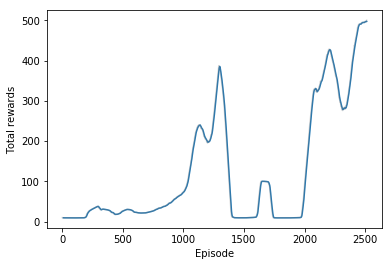

In [32]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

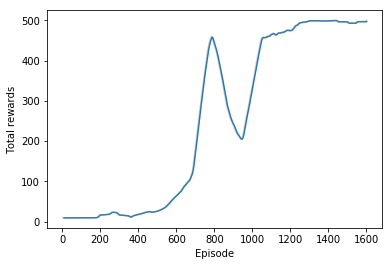

In [28]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

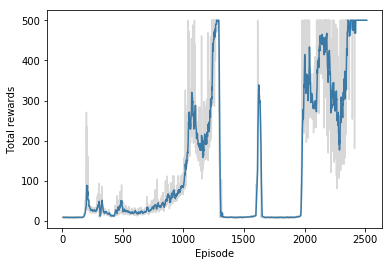

In [33]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

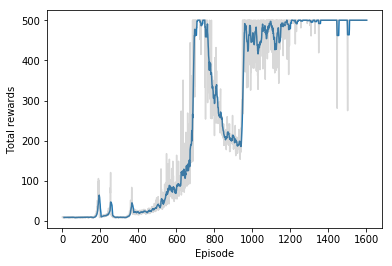

In [30]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

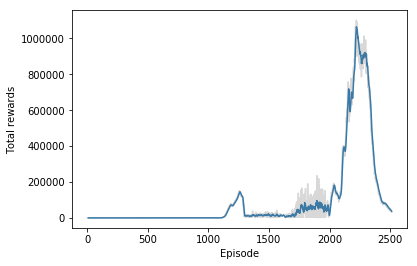

In [34]:
eps, arr = np.array(loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

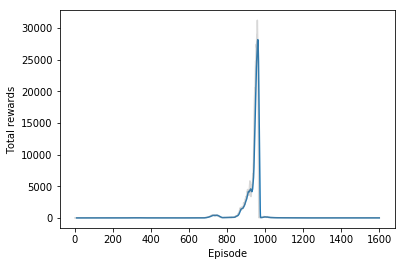

In [31]:
eps, arr = np.array(loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

## Testing

Let's checkout how our trained agent plays the game.

In [35]:
# Creating a gym env
import gym

# env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')

# A training graph session
with tf.Session(graph=graph) as sess:
    #sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(10):
        state = env.reset()
        total_reward = 0

        # Steps/batches
        while True:
            env.render()
            
            action, _ = act(sess, state)
            
            state, reward, done, _ = env.step(action)
            
            total_reward += reward
            
            if done:
                break
                
        # Closing the env
        print('total_reward: {}'.format(total_reward))

# Close the env at the end
env.close()

INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt


/home/arasdar/anaconda3/lib/python3.6/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0


## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.